<a href="https://colab.research.google.com/github/JoseAdFer/IDAL_IA3_JoseAdell/blob/main/Ejercicio_Jumanji_modelo1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

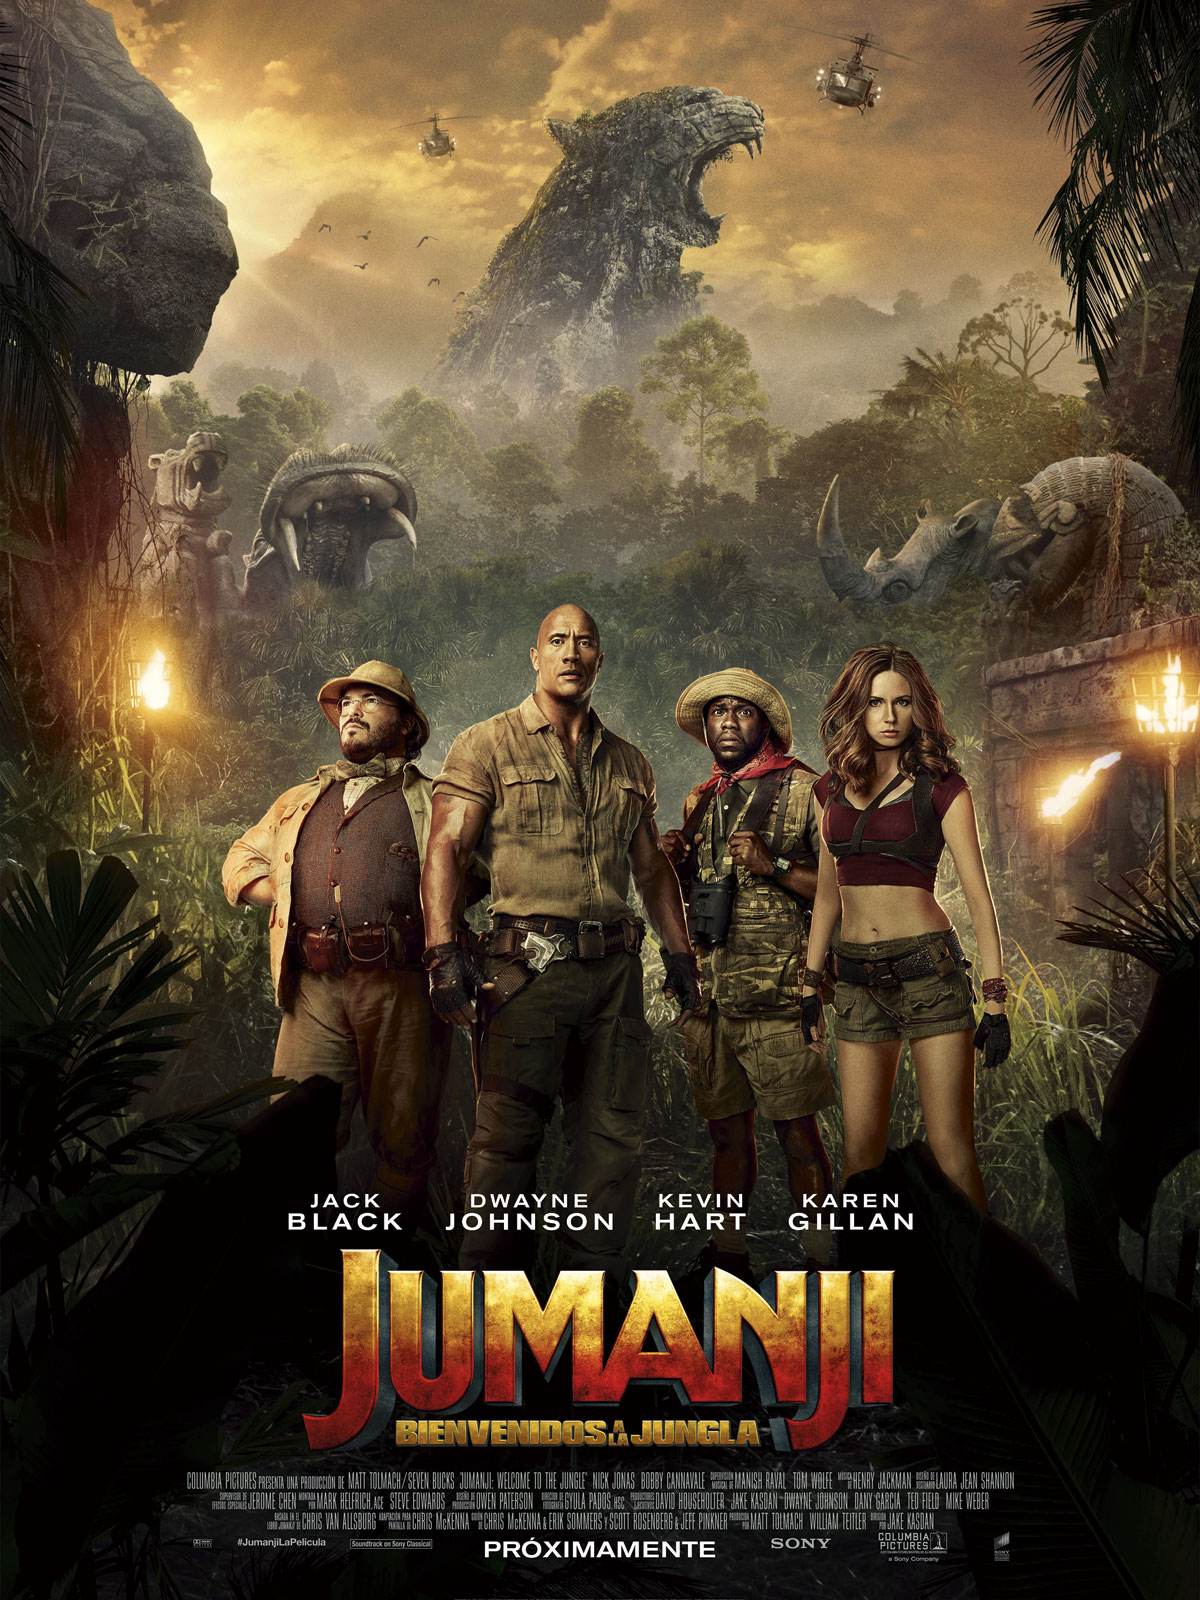

# Ejercicio Jumanji - Bienvenidos a la jungla

Wellcome to Jumanji dear adventurers. Unfortunately not everything are good news, some players have been playing to the game and, as a result of they dumb plays, a stampede of cats and dogs is now running in the real world.

As a fellow explorer I am sure that you understand the urgency of the situation. To solve it, we need to create a computer vision algorithm using CNNs to detect the cats and the dogs.

In order to do so we require the following steps:

- Create an image preprocessing pipeline to treat the images that we are providing. Perform data augmentation over the dataset, at least rotations.

- Test several architechtures (at least 3) and evaluate their performance over the dataset.

- Visualize the feature maps of some of the early and late layers of the models developed. ¿Is there any feature which could be explained through them?

- Finally select the model which performs the best over the whole dataset and explain why.

Fellow adventurer, thanks for your time, Jumanji will not forget your efforts.

# **Carga y preprocesado de datos**

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /content/cats_and_dogs_filtered.zip
!unzip cats_and_dogs_filtered.zip

--2021-12-29 10:11:13--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

/content/cats_and_d 100%[===================>]  65.43M   170MB/s    in 0.4s    

2021-12-29 10:11:14 (170 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Archive:  cats_and_dogs_filtered.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/vali

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [3]:
img = Image.open("cats_and_dogs_filtered/train/cats/cat.10.jpg")
array_image = np.array(img)
array_image.shape

(499, 489, 3)

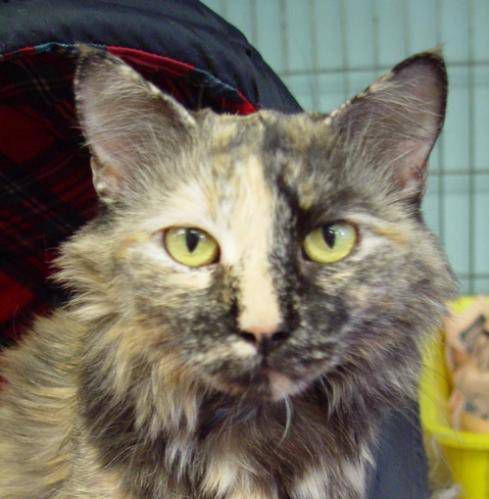

In [4]:
img

In [4]:
def change_resolution(img, desired_resolution):
  width, height = img.size
  if width > height:
    aspect_relatio = width/height
    new_width = desired_resolution
    new_height = round(desired_resolution/aspect_relatio)
    resized_img = img.resize((new_width,new_height))
  else:
    aspect_relatio = height/width
    new_height = desired_resolution
    new_width = round(desired_resolution/aspect_relatio)
    resized_img = img.resize((new_width,new_height))
  return resized_img

def pad_img(img, desired_resolution):
  width, height = img.size
  array = np.array(img)
  if width > height:
    total_pad = desired_resolution - height
    pad = total_pad/2
    if isinstance(pad, float):
      pad_0 = int(np.ceil(pad))
      pad_1 = int(np.floor(pad))
      padded_image = np.pad(array, ((pad_0, pad_1),(0,0),(0,0)))
    else:
      padded_image = np.pad(array, ((pad, pad),(0,0),(0,0)))
  else:
    total_pad = desired_resolution - width
    pad = total_pad/2
    if isinstance(pad, float):
      pad_0 = int(np.ceil(pad))
      pad_1 = int(np.floor(pad))
      padded_image = np.pad(array, ((0,0),(pad_0, pad_1),(0,0)))
    else:
      padded_image = np.pad(array, ((0,0),(pad, pad),(0,0)))
  return padded_image

In [5]:
def rot_image(img, max_degree, por_image):
  por=np.random.randint(0,100)
  if por>(100-por_image):
    n=np.random.randint(-max_degree, max_degree)
    rotated_image=img.rotate(n)
  else: 
    rotated_image=img
  return rotated_image

In [6]:
import os
import random
from PIL import ImageFilter

In [7]:
np.random.seed(123)

In [8]:
cat_files = os.listdir("cats_and_dogs_filtered/train/cats")
dog_files = os.listdir("cats_and_dogs_filtered/train/dogs")

In [39]:
preprocess_path = "preprocessed_dataset/train/cats" 
os.makedirs(preprocess_path, exist_ok=True)
for file_ in cat_files:
  path = os.path.join("cats_and_dogs_filtered/train/cats", file_)
  img = Image.open(path)
  resized_img = change_resolution(img, 150)
  padded_img = pad_img(resized_img, 150)
  preprocessed_image = Image.fromarray(padded_img)
  rotated_img=rot_image(preprocessed_image,20,30)  
  save_path = os.path.join(preprocess_path, file_)
  rotated_img.save(save_path)

In [40]:
preprocess_path = "preprocessed_dataset/train/dogs" 
os.makedirs(preprocess_path, exist_ok=True)
for file_ in dog_files:
  path = os.path.join("cats_and_dogs_filtered/train/dogs", file_)
  img = Image.open(path)
  resized_img = change_resolution(img, 150)
  padded_img = pad_img(resized_img, 150)
  random.randint(0, 100)
  preprocessed_image = Image.fromarray(padded_img)
  rotated_img=rot_image(preprocessed_image,20,30) 
  save_path = os.path.join(preprocess_path, file_)
  rotated_img.save(save_path)

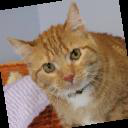

In [11]:
img = Image.open("preprocessed_dataset/train/cats/cat.194.jpg")
img

# **Modelo**

In [12]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras import optimizers
from keras import models
from glob import glob
import cv2
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

%matplotlib inline

In [41]:
train_data_dir = 'preprocessed_dataset/train'
validation_data_dir = 'cats_and_dogs_filtered/validation'
batch_size = 32

In [42]:
train_datagen = ImageDataGenerator(
    dtype='float32')

val_datagen  = ImageDataGenerator(dtype='float32')


In [43]:
train_generator = keras.preprocessing.image_dataset_from_directory(train_data_dir,
                                                                   batch_size=32,
                                                                   image_size=(150,150),
                                                                   crop_to_aspect_ratio=True,
                                                                   label_mode="categorical")
validation_generator = keras.preprocessing.image_dataset_from_directory(validation_data_dir,
                                                                   batch_size=32,
                                                                   image_size=(150,150),
                                                                   crop_to_aspect_ratio=True,
                                                                   label_mode="categorical")

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [44]:
number_train_samples = 2000
number_val_samples   = 1000


In [20]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [78]:
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

In [79]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu',
                 input_shape=(150,150)+(3,)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
# aqui empieza la red neuronal 'standard'
model.add(Dropout(0.3))
model.add(Dense(90, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy',
#              optimizer=optimizers.RMSprop(lr=1e-4),
#              optimizer=optimizers.RMSprop(),
              optimizer="rmsprop",
              metrics=['accuracy'])

In [34]:
model.fit(train_generator)

63/63 [==============================] - 2s 33ms/step - loss: 1.0034 - accuracy: 0.5275


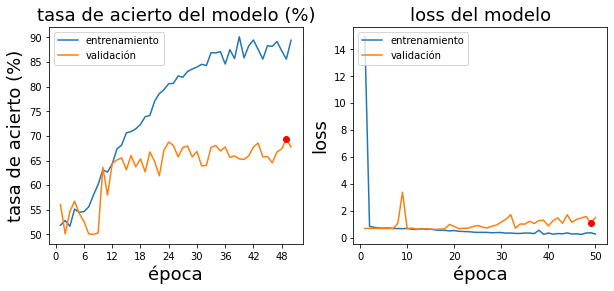

In [80]:
epochs = 50

modelpath="model_current_best_parte3.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]
for e in range(epochs):
    history = model.fit(train_generator, 
                        steps_per_epoch=number_train_samples // batch_size,
                        epochs=1,
                        callbacks=callbacks_list,
                        verbose=1,
                        shuffle = True,
                        validation_data=validation_generator,
                        validation_steps=number_val_samples // batch_size
                       )
    
    if history.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_accuracy'][-1]
    
    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [81]:
model = load_model(modelpath)

In [82]:
scores_tr = model.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

63/63 [==============================] - 3s 38ms/step - loss: 0.1413 - accuracy: 0.9480
Train loss    : 0.1413346827030182
Train accuracy: 0.9480000138282776

32/32 [==============================] - 3s 76ms/step - loss: 1.1055 - accuracy: 0.6910
Val loss    : 1.1055389642715454
Val accuracy: 0.6909999847412109

